# Bitcoin Price/Trend Prediction 
Created by Jamil Abbas  
Last Updated: 2021-05-10

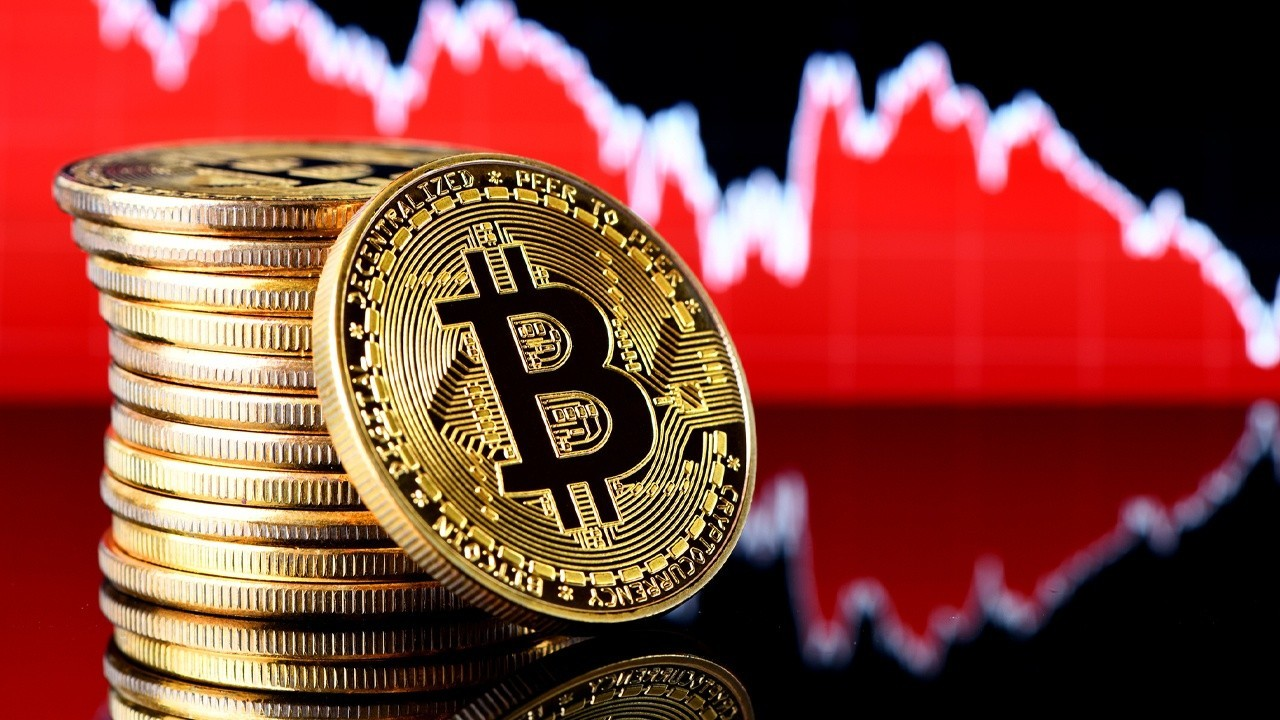

Bitcoin is a digital currency (known as cryptocurrency) that was developed in 2009. Cryptocurrencies exist exclusively online as there is no physical bitcoins, but rather the balances of bitcoin are kept on a publically transparent ledger.
Bitcoin operates on a collection of computers, sometimes referred to as 'nodes', that run the bitcoin code and store whats known as the bitcoin blockchain. The blockchain is a collection of blocks which hold a series of transactions that have occured. All nodes run the same code with the same blockchain to deter people from falsifying or cheating the system.   
  
Bitcoin is a decentralized currency (doesn't operate under a government) which aims to minimize transaction fees and limitations that traditional currencies hold. While the benefits are enticing, there are numerous forms of risk that arise from having a decentralized currency. The types of risk include: regulatory risk, security risk, insurance risk, fraud risk, and market risk. 
The anonymity of bitcoin transactions could attract ill-motivated movements of currency (eg. black market sales, money laundering, illegal activities, tax evasion) which could result in motivating governments to regulate/restrict the use of cryptocurrency. This questions the longevity and survivability of bitcoin and poses a regulatory risk.
The majority of bitcoin is bought and sold through websites known as bitcoin exchanges. This poses a security risk as hackers could target these bitcoin exchanges and gain access to thousands of wallets and do what they please with them. 
Some investments and most bank accounts are insured through the government. On the contrary bitcoin wallets/transactions aren't insured at all and this poses a insurance risk.  
  
Given all the benefits and risks described above, the one aspect about bitcoin that can be confirmed is that the price is volitile. Whether or not Bitcoin or cryptocurrencies as a whole will remain relevant in the near and distant future, there is value in determining and predicting the trend at which the price operates. 
This project aims to determine if there is an observable time series statistical relationship/trend that can be uncovered to predict the price of bitcoin. Pure statistical methods are tested (auto-regressive intgrated moving average and vector autoregressive models) despite the fact that the price of bitcoin isn't stationary and volitile. This is done to determine if such a relationship exists, but not to be used as a sort of 'trading bot' to make invesment decisions on. 

In [1]:
from datetime import datetime, date
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR


%matplotlib inline

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d') 

#Import the data
#Set the 'Date' column as the index of the dataframe
#Use the user defined parser function above to convert the index from a string to a datetime object
#Remove any null values from the data set if there are any
df_BTC = pd.read_csv("./data/BTC_USD.csv", index_col=1, parse_dates=[1], date_parser=parser)
df_BTC.asfreq('D')
df_BTC = df_BTC.dropna()
print('Shape of Data: ', df_BTC.shape)
df_BTC

Shape of Data:  (2782, 5)


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-09,BTC,58102.191426,58966.915010,59249.141676,56494.915334
2021-05-10,BTC,55715.546651,58308.318048,59560.025459,53774.628243
2021-05-11,BTC,56573.555472,55899.752971,56956.075029,54571.693210


Text(0, 0.5, 'Closing Price (USD)')

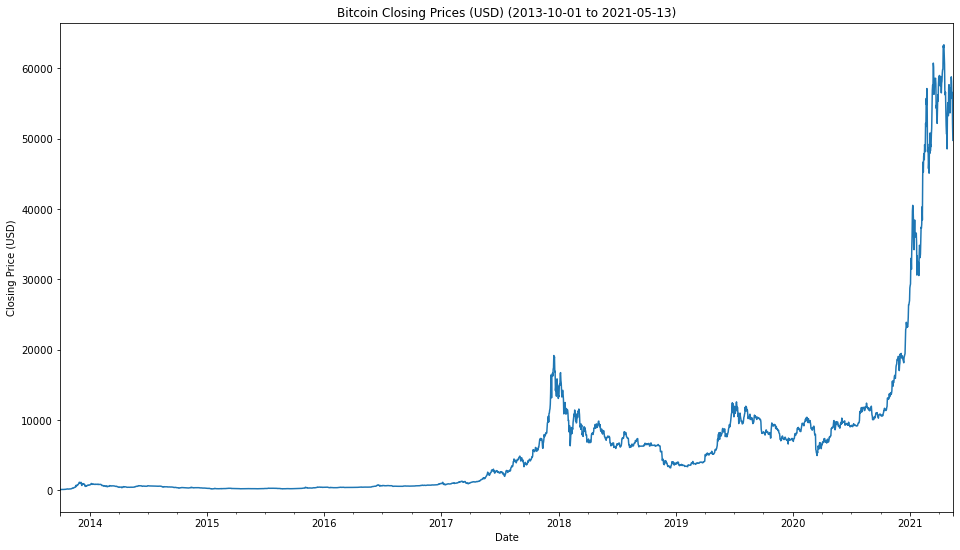

In [3]:
#Plot the total dataset
plt.figure(figsize=(16,9))
total_data = df_BTC['Closing Price (USD)']
total_data.plot()


plt.title('Bitcoin Closing Prices (USD) (2013-10-01 to 2021-05-13)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')

In [4]:
#Subset the dataframe to the dates we wish to use for analysis
#Drop all columns except for 'Closing Price (USD)' as this is the data we wish to use for analysis
df_BTC = df_BTC['2017-01-01':'2021-04-30']
df_BTC.drop(['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'], axis=1, inplace = True)
df_BTC

,Closing Price (USD)
Date,
2017-01-01,964.325000
2017-01-02,1009.973750
2017-01-03,1028.333750
2017-01-04,1047.099990
2017-01-05,1140.385000
...,...
2021-04-26,53558.707845
2021-04-27,55123.861981
2021-04-28,54591.515326


Text(0, 0.5, 'Closing Price (USD)')

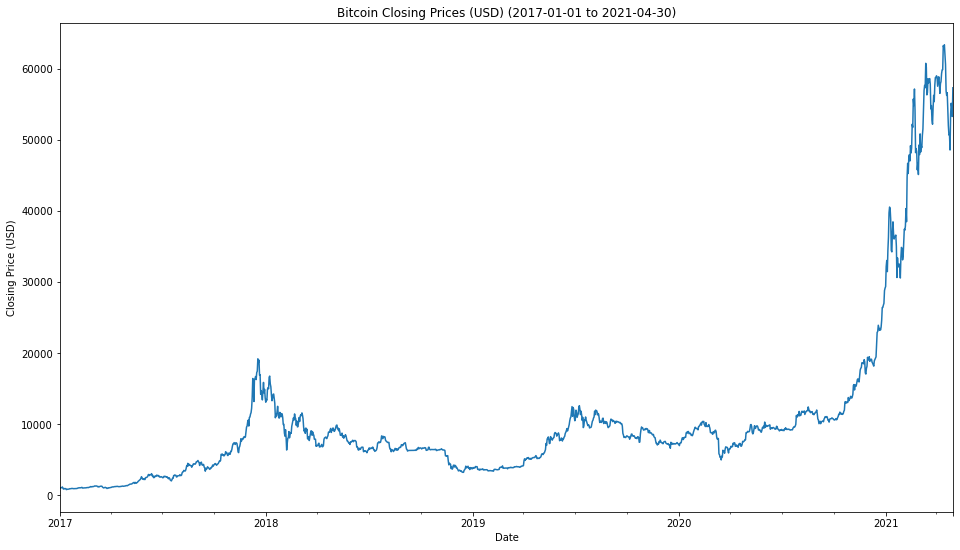

In [5]:
#Plot the subset of the data we wish to use
plt.figure(figsize=(16,9))
df_BTC['Closing Price (USD)'].plot()
plt.title('Bitcoin Closing Prices (USD) (2017-01-01 to 2021-04-30)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')

### Stationarity 

In order to utilize the ARIMA model, the input series has to be stationary. While it is trivial to ask whether or not the price of bitcoin is stationary based on the graphs above, the stationarity is explored and differencing is utilzed to make the series stationary.  

In [4]:
#Custom made function that performs the Augmented-Dickey Fuller unit root test on a series
#In addition creates a graph containing the series, rolling mean, and rolling standard deviation 

def test_stationarity(x, title=''):
    
    #Determine and plot the rolling statistics (mean and standard deviation)
    rmean = x.rolling(window=26, center=False).mean()
    rSTD = x.rolling (window=15, center=False).std()
    
    #Plot the rolling statistics
    plt.figure(figsize=(16,9))
    x.plot(color='Blue', label='Original')
    rmean.plot(color='Red', label='Rolling Mean')
    rSTD.plot(color='Green', label='Rolling STD')
    plt.legend(loc='best')
    title_str = str(title + ' Rolling Meand and STD')
    plt.title(title_str)
    
    #Perform the ADF unit-root test
    adf = adfuller(x)
    print('ADF Test Statistic: %f'  %adf[0])
    print('P-Value: %f' %adf[1])
    

ADF Test Statistic: 2.709011
P-Value: 0.999087


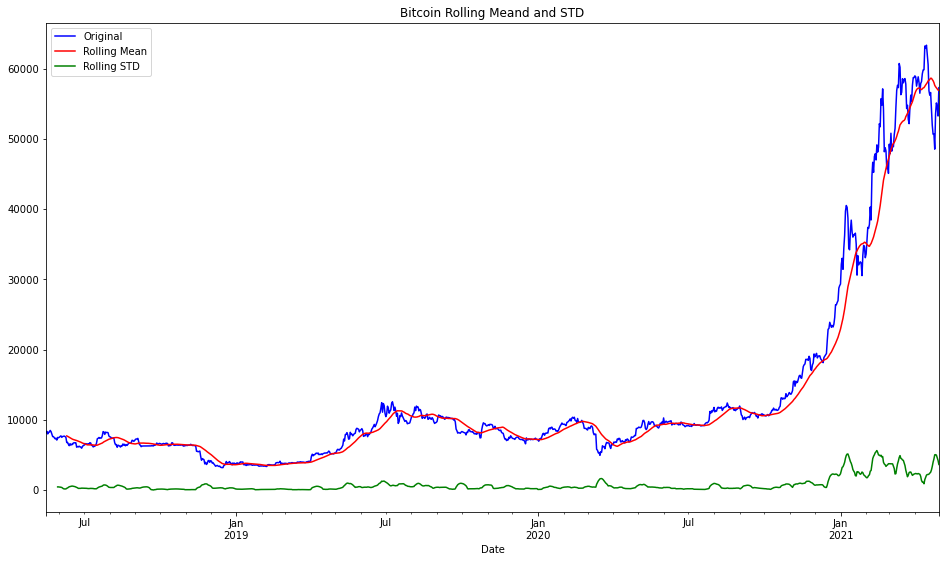

In [133]:
test_stationarity(df_BTC['Closing Price (USD)'], title='Bitcoin')
#Given the P-Value = 0.99 > 0.05, fail to reject the null, series has a unit root

In [8]:
#Take the difference of the series
BTC_diff = df_BTC.diff(periods=1)
#Remove the first data point
BTC_diff = BTC_diff[1:]
BTC_diff.head()

,Closing Price (USD)
Date,
2017-01-02,45.64875
2017-01-03,18.36000
2017-01-04,18.76624
2017-01-05,93.28501
2017-01-06,-154.44625


ADF Test Statistic: -8.820885
P-Value: 0.000000


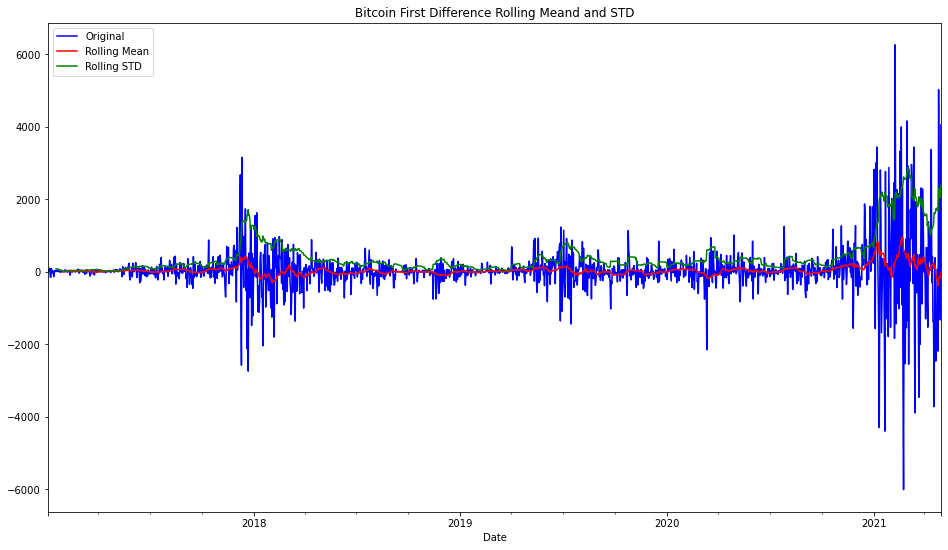

In [134]:
test_stationarity(BTC_diff['Closing Price (USD)'], 'Bitcoin First Difference')
#Given P-Value =0 < 0.05, reject the null, the series doesn't have a unit root

## Auto-Regressive Integrated Moving Average (ARIMA) Model

In [10]:
#Utilize pmdarima's auto_arima function to test different parameters of p,d,q values and return the optimal model based on the AIC information
warnings.filterwarnings('ignore')

step_fit = auto_arima(df_BTC['Closing Price (USD)'], trace=True, suppress_warnings=True)
step_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=26141.479, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=25642.632, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=25421.516, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=25326.397, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=25304.472, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=25235.629, Time=0.12 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.45 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.27 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=25237.610, Time=0.26 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 5.259 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1581
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -12611.815
Date:                Fri, 14 May 2021   AIC                          25235.629
Time:                        20:20:43   BIC                          25267.817
Sample:                             0   HQIC                         25247.589
                               - 1581                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8632      0.009    -91.130      0.000      -0.882      -0.845
ar.L2         -0.6766      0.013    -51.441      0.000      -0.702      -0.651
ar.L3         -0.4712      0.015    -30.511      0.000      -0.501      -0.441
ar.L4         -0.3014      0.015    -19.464      0.000      -0.332      -0.271
ar.L5         -0.2159      0.010    -22.121      0.000      -0.235      -0.197
sigma2      5.084e+05   5462.691     93.075      0.000    4.98e+05    5.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):             40444.93
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               4.90   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
#Split the data into train and test data
#Set test data to the month of April 2020
split = 30
train, test = df_BTC[0:len(df_BTC)-split], df_BTC[len(df_BTC)-split:]
print('Training Data Shape : ', train.shape, '\n Testing Data Shape', test.shape)

Training Data Shape :  (1551, 1) 
 Testing Data Shape (30, 1)


In [12]:
test1 = [x for x in test['Closing Price (USD)']]

#Apply the ARIMA model
history = [x for x in train['Closing Price (USD)']]
pred=[]
error=[]

for t in range(len(test)):
    model = ARIMA(history, order=(5,2,0))
    model_fit = model.fit()
    
    result = model_fit.forecast(typ='level')
    pred_val = result[0]
    pred.append(pred_val)
    history.append(test1[t])
    err = ((abs(pred_val - test1[t])) / test1[t]) * 100
    error.append(err)
    print('predicted = %f,   actual = %f,   error = %f ' % (pred_val, test1[t], err), '%')

predicted = 60009.813042,   actual = 58984.612930,   error = 1.738081  %
predicted = 59844.376286,   actual = 58821.626994,   error = 1.738730  %
predicted = 59088.078442,   actual = 57517.798773,   error = 2.730076  %
predicted = 58011.700464,   actual = 58177.402764,   error = 0.284822  %
predicted = 58254.693351,   actual = 58843.559540,   error = 1.000732  %
predicted = 58790.257849,   actual = 58040.187602,   error = 1.292329  %
predicted = 58064.387053,   actual = 56508.942864,   error = 2.752563  %
predicted = 56205.260361,   actual = 57880.905684,   error = 2.894988  %
predicted = 57475.465123,   actual = 58171.909019,   error = 1.197217  %
predicted = 58251.154674,   actual = 59295.950044,   error = 1.762001  %
predicted = 59607.665352,   actual = 59822.901677,   error = 0.359789  %
predicted = 59997.124076,   actual = 59853.197242,   error = 0.240466  %
predicted = 60048.486825,   actual = 63223.884391,   error = 5.022465  %
predicted = 64242.857206,   actual = 62926.557176, 

In [13]:
#Create a dataframe with the predictions and actual values for plotting
data_df = pd.DataFrame(columns=['Predicted', 'Actual'])
data_df['Predicted'] = pred
data_df['Actual'] = test1
df_index = pd.date_range(start='2021-04-01', end='2021-04-30')
data_df.index = df_index
data_df.head()

,Predicted,Actual
2021-04-01,60009.813042,58984.612930
2021-04-02,59844.376286,58821.626994
2021-04-03,59088.078442,57517.798773
2021-04-04,58011.700464,58177.402764
2021-04-05,58254.693351,58843.559540


Mean Average Prediction Error:  2.680421761585433 %


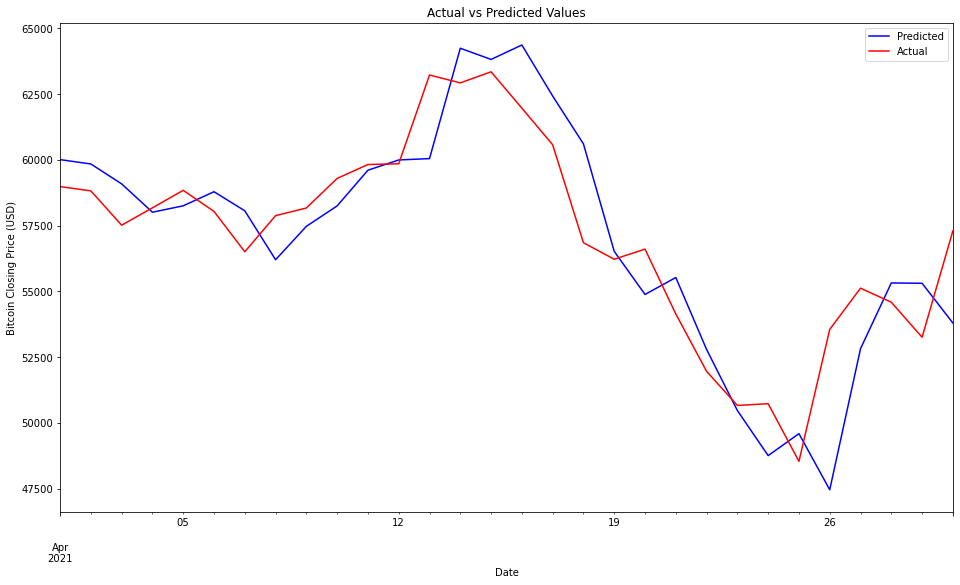

In [14]:
#Plot predicted vs actual data
plt.figure(figsize=(16,9))
data_df['Predicted'].plot(color='Blue', legend=True)
data_df['Actual'].plot(color='Red', legend=True)
plt.ylabel('Bitcoin Closing Price (USD)')
plt.xlabel('Date')
plt.title('Actual vs Predicted Values')

#Calculate mean average error accross all predictions
total_error = sum(error)/float(len(error))
print('Mean Average Prediction Error: ', total_error, '%')

### Pitfalls

Despite the error values, the ARIMA model doesn't inform us about the trend at which the price of Bitcoin moves. The predictions are done by predicting a single time-step into the future (in this case 1 day) which doesn't provide the user with much. However, this was expected as predicting the price of Bitcoin with only previous values of the price is nearly impossible. The next aspect of this projects helps tackle this issue by including features that could help us predict the trend. 

## Vector Autoregressive (VAR) Model

To combat the issues of the ARIMA model, a vector autoregressive model was implemented to help extract trends from feature variables that could assist in predicing the price of bitcoin. The features that were chosen are:  
* **Market-cap**: The total USD value of bitcoin in circulation $^4$   
* **Total Hash rate**: The estimated number of terahashes per second the bitcoin network is performing in the last 24 hours. Hashrate is a bitcoin security metric, the more hashing the greater its security. $^3$   
* **Unspent Transaction Outputs (UTXO)**: The total number of valid unspent transaction outputs. $^2$  
* **Ethereum**: Price of Etereum in USD $^2$ 
* **Litecoin**: Price of Litecoin in USD $^1$ 

In [113]:
#Import predicting variables as dataframes and adjust them so that their index is by date and on the range ('2018-05-16', '2021-04-30') 



#Import market cap
df_mc = pd.read_csv('./data/market-cap.csv')
df_mc['Timestamp'] = pd.to_datetime(df_mc['Timestamp']).dt.date #Extract date without time
df_mc['Timestamp'] = pd.to_datetime(df_mc['Timestamp'], format='%Y-%m-%d') #change back to datetime object after extracting the date
df_mc['market-cap'] = df_mc['market-cap'] / 1000000000 #Divide by 1,000,000,000 to scale values 
df_mc.drop_duplicates(subset=['Timestamp'], keep='first', inplace=True)
df_mc.set_index(['Timestamp'], inplace=True)
df_mc = df_mc.sort_index()
df_mc = df_mc['2018-05-16':'2021-04-30']


#Import hash rate 
#Hash rate is 7-day average
df_hr = pd.read_csv('./data/hash-rate.csv', index_col=['Timestamp'], parse_dates=['Timestamp'])
df_hr['hash-rate'] = df_hr['hash-rate'] / 100000 #Divide by 100,000 to scale values
df_hr = df_hr['2018-05-16':'2021-04-30']

#Import Unspent transaction outputs
df_utxo = pd.read_csv('./data/utxo-count.csv')
df_utxo['Timestamp'] = pd.to_datetime(df_utxo['Timestamp']).dt.date #Extract date without time
df_utxo['Timestamp'] = pd.to_datetime(df_utxo['Timestamp'], format='%Y-%m-%d') #change back to datetime object after extracting the date
df_utxo['utxo-count'] = df_utxo['utxo-count'] / 1000000 #Divide by 1,000,000 to scale values 
df_utxo.drop_duplicates(subset=['Timestamp'], keep='first', inplace=True)
df_utxo.set_index(['Timestamp'], inplace=True)
df_utxo = df_utxo['2018-05-16':'2021-04-30']

#Import ethereum prices
df_eth = pd.read_csv('./data/ETH_USD.csv', index_col=['Date'], parse_dates=['Date'])
df_eth = df_eth[['Closing Price (USD)']]
df_eth = df_eth['2018-05-16':'2021-04-30']

#Import litecoin price
df_ltc = pd.read_csv('./data/LTC-USD.csv', index_col=['Date'], parse_dates=['Date'])
df_ltc = df_ltc[['Close']]
df_ltc = df_ltc['2018-05-16':'2021-04-30']
df_ltc.fillna(method='ffill', inplace=True)

#Adjust bitcoin df date range
df_BTC = df_BTC['2018-05-16':'2021-04-30']

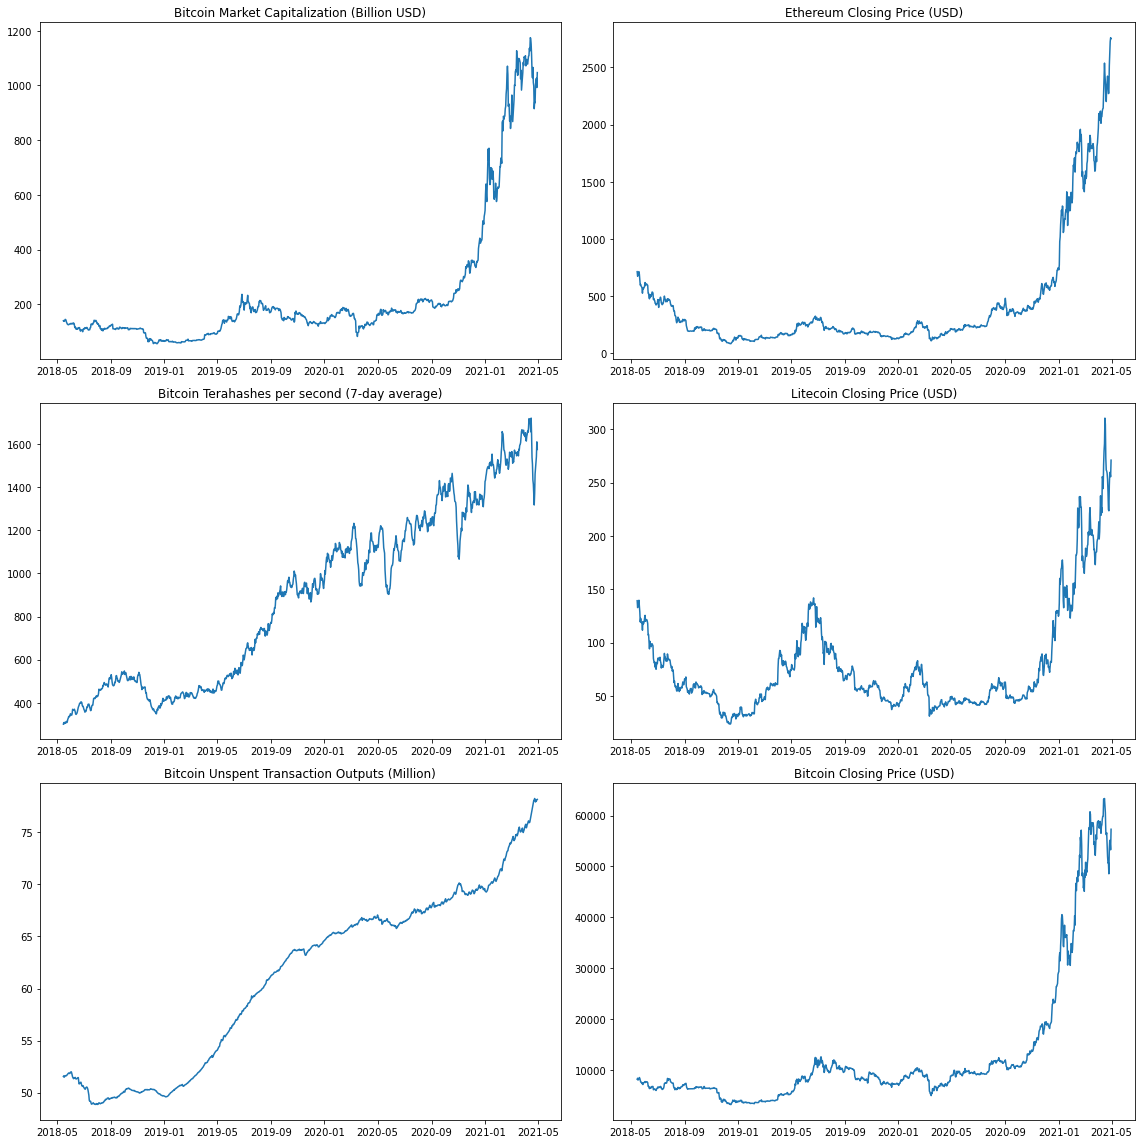

In [115]:
#Plot all of the variables
fig, axs = plt.subplots(3,2, figsize=(16,16))
axs[0,0].plot(df_mc['market-cap'])
axs[0,0].set_title('Bitcoin Market Capitalization (Billion USD)')

axs[1,0].plot(df_hr['hash-rate'])
axs[1,0].set_title('Bitcoin Terahashes per second (7-day average)')

axs[2,0].plot(df_utxo['utxo-count'])
axs[2,0].set_title('Bitcoin Unspent Transaction Outputs (Million)')

axs[0,1].plot(df_eth[['Closing Price (USD)']])
axs[0,1].set_title('Ethereum Closing Price (USD)')

axs[1,1].plot(df_ltc[['Close']])
axs[1,1].set_title('Litecoin Closing Price (USD)')

axs[2,1].plot(df_BTC[['Closing Price (USD)']])
axs[2,1].set_title('Bitcoin Closing Price (USD)')

fig.tight_layout()

In [117]:
#Combine all data into single dataframe

date_index = pd.date_range('2018-05-16', '2021-04-30')

df_var = pd.DataFrame(date_index)
df_var['bitcoin'] = df_BTC['Closing Price (USD)'].array
df_var['market-cap'] = df_mc['market-cap'].array
df_var['hash-rate'] = df_hr['hash-rate'].array
df_var['utxo-count'] = df_utxo['utxo-count'].array
df_var['ethereum'] = df_eth['Closing Price (USD)'].array
df_var['litecoin'] = df_ltc['Close'].array
df_var.set_index(date_index, inplace=True)
df_var = df_var[df_var.columns[1:]]
df_var

,bitcoin,market-cap,hash-rate,utxo-count,ethereum,litecoin
2018-05-16,8159.256250,139.827689,300.976603,51.548840,713.386000,139.268005
2018-05-17,8360.228750,140.826694,307.952003,51.613765,673.300000,132.772995
2018-05-18,7996.821250,137.747892,302.810175,51.481885,695.009000,136.057007
2018-05-19,8237.342500,139.377793,308.989974,51.560908,706.022000,135.320007
2018-05-20,8250.395000,144.640900,305.752937,51.590203,713.500000,139.697998
...,...,...,...,...,...,...
2021-04-26,53558.707845,1003.073111,1490.453320,77.929035,2515.309504,247.405930
2021-04-27,55123.861981,1019.492922,1518.922653,78.087568,2624.355719,259.652283
2021-04-28,54591.515326,1026.334198,1542.367986,78.022998,2726.152032,258.505157
2021-04-29,53260.295341,992.380744,1611.029319,78.138546,2760.334956,255.585266


### Causation

To determine whether our features are useful in predicting the price of bitcoin, the granger causality test is utilzed. $^6$

In [118]:
# Import function grangers_causation_matrix to test causation between the time series variables
maxlag = 12

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_var, variables=df_var.columns)

,bitcoin_x,market-cap_x,hash-rate_x,utxo-count_x,ethereum_x,litecoin_x
bitcoin_y,1.0000,0.00,0.0000,0.0107,0.0000,0.0000
market-cap_y,0.0000,1.00,0.0000,0.0013,0.0000,0.0000
hash-rate_y,0.0305,0.01,1.0000,0.0000,0.0125,0.1718
utxo-count_y,0.0000,0.00,0.0000,1.0000,0.0000,0.0000
ethereum_y,0.0000,0.00,0.0080,0.0134,1.0000,0.0000
litecoin_y,0.0000,0.00,0.0039,0.0014,0.0000,1.0000


Given that all the results that aren't on the diagonal of the matrix are less than 0.05, we can conlude that the features are all useful in predicting price of bitcoin in a time series. 

### Stationarity

Like the previous model, all the series have to be stationary for the VAR model. The same 'test_stationarity' function is used. 

In [119]:
#Split data into train/test dataset
split = 30
df_var_train, df_var_test = df_var[0:len(df_BTC)-split], df_var[len(df_BTC)-split:]
print('Training Data Shape : ', train.shape, '\n Testing Data Shape', test.shape)

Training Data Shape :  (1551, 1) 
 Testing Data Shape (30, 1)


bitcoin
ADF Test Statistic: 2.709011
P-Value: 0.999087
market-cap
ADF Test Statistic: 3.006927
P-Value: 1.000000
hash-rate
ADF Test Statistic: -0.103592
P-Value: 0.949080
utxo-count
ADF Test Statistic: 0.991368
P-Value: 0.994174
ethereum
ADF Test Statistic: 5.439165
P-Value: 1.000000
litecoin
ADF Test Statistic: 1.206872
P-Value: 0.996033


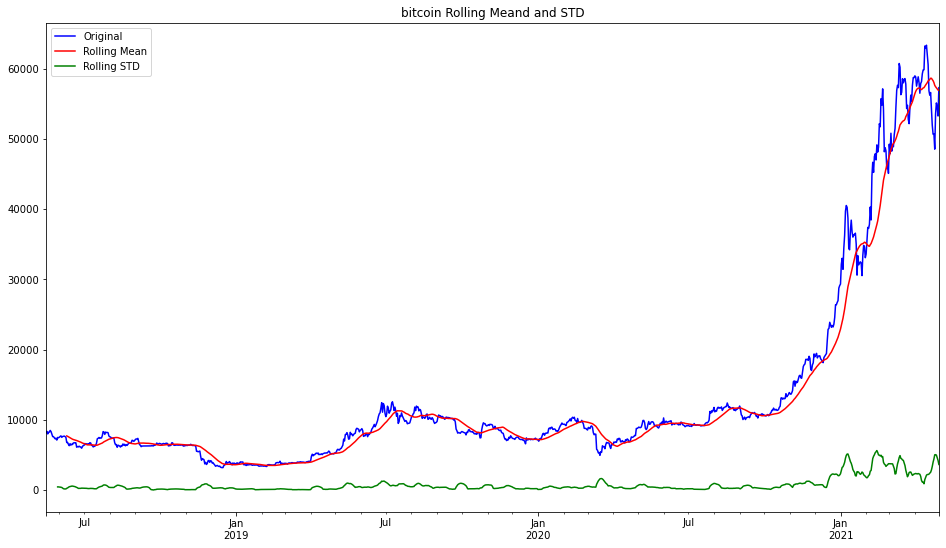

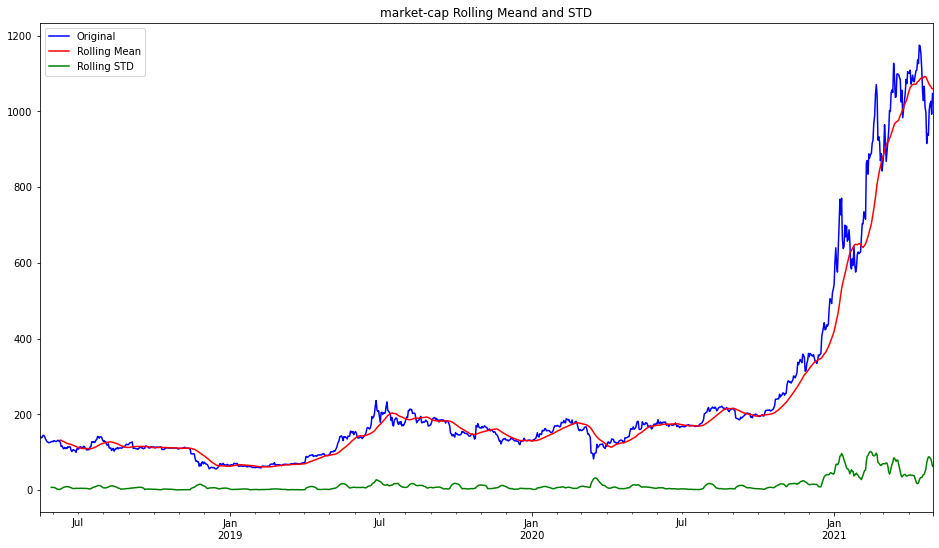

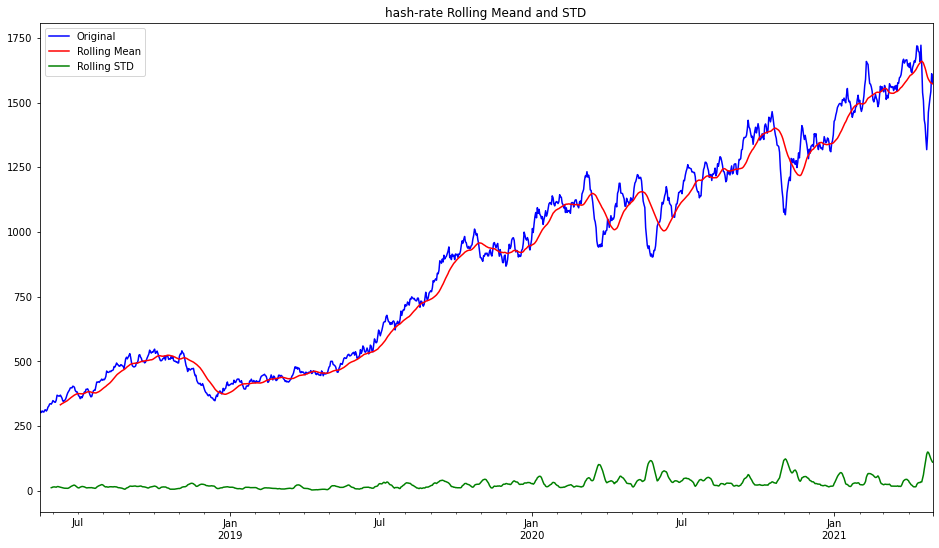

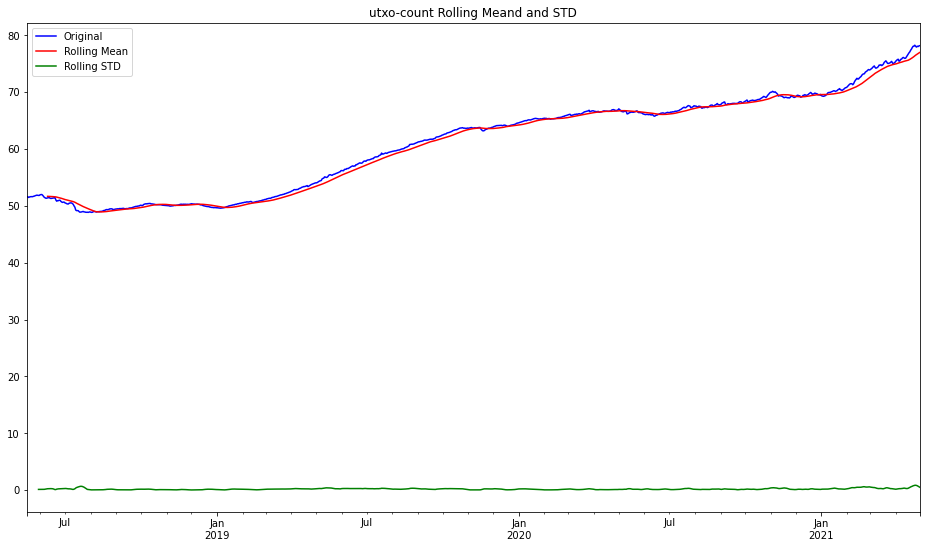

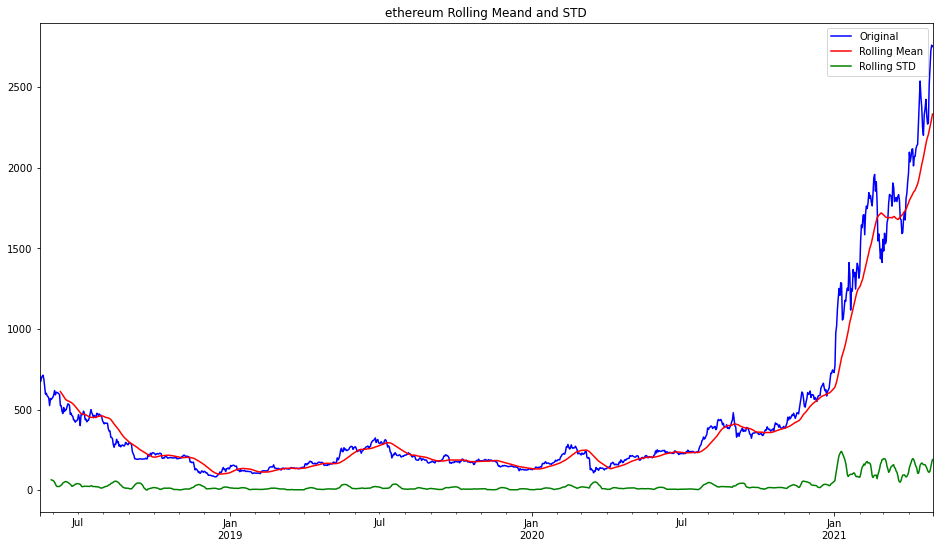

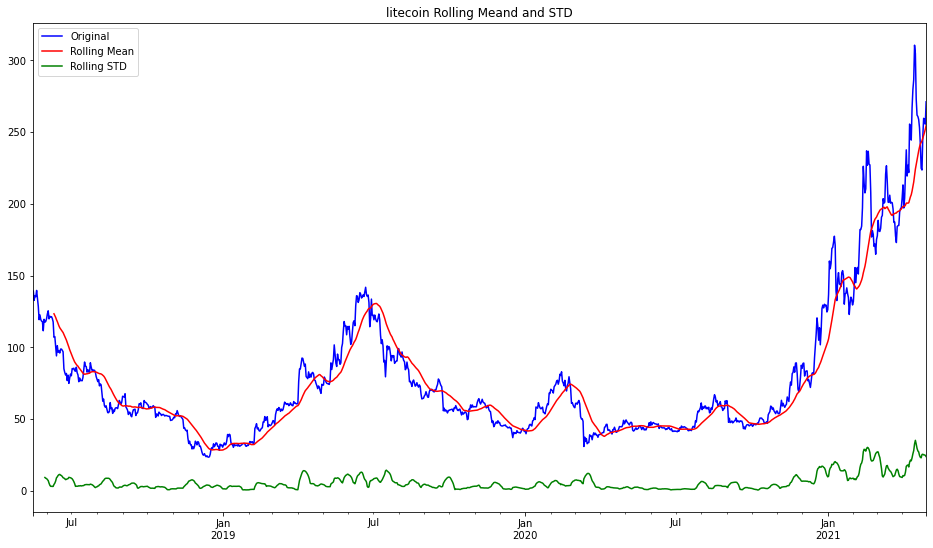

In [135]:
#Perform augmented dickey fuller unit root tests on all variables
for i in df_var_train.columns:
    print(i)
    test_stationarity(df_var[i], title=i)

bitcoin
ADF Test Statistic: -6.367396
P-Value: 0.000000
market-cap
ADF Test Statistic: -7.025458
P-Value: 0.000000
hash-rate
ADF Test Statistic: -9.134369
P-Value: 0.000000
utxo-count
ADF Test Statistic: -4.416294
P-Value: 0.000278
ethereum
ADF Test Statistic: -6.708359
P-Value: 0.000000
litecoin
ADF Test Statistic: -8.547799
P-Value: 0.000000


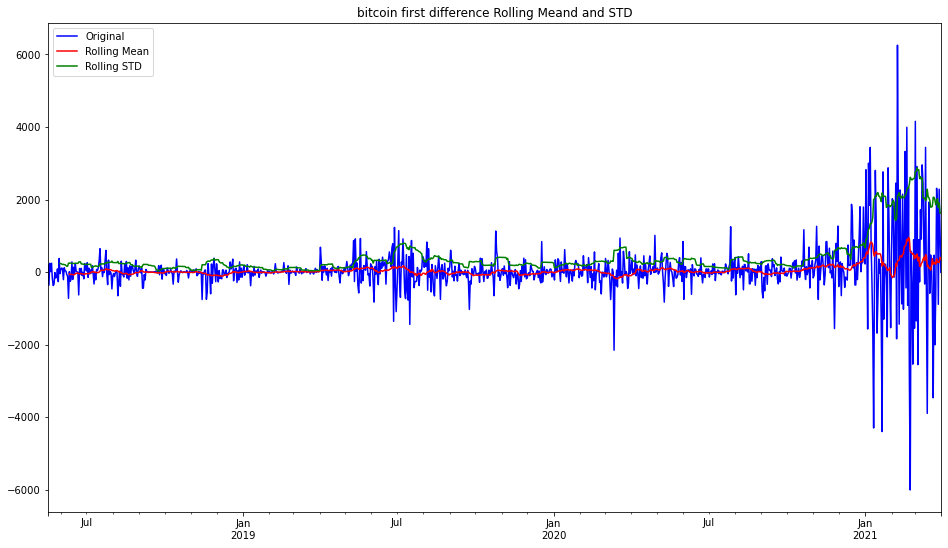

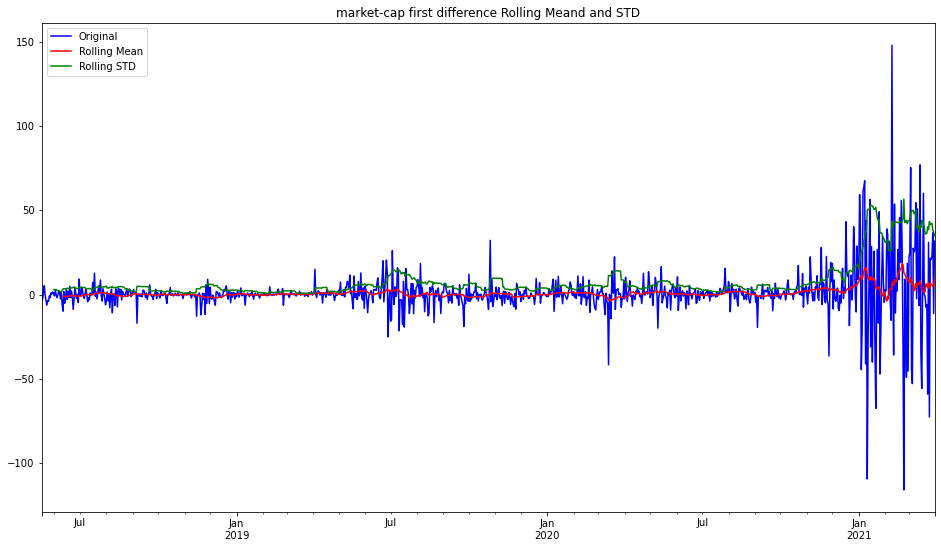

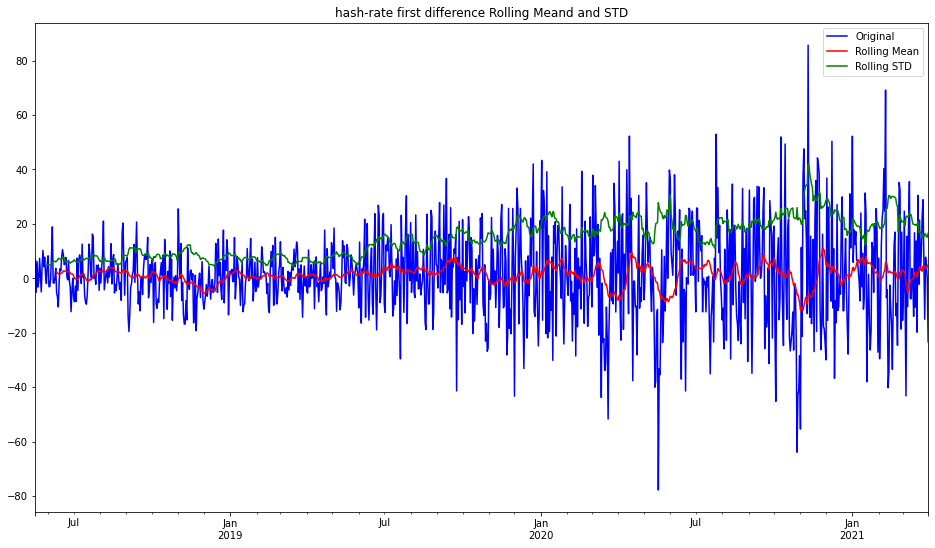

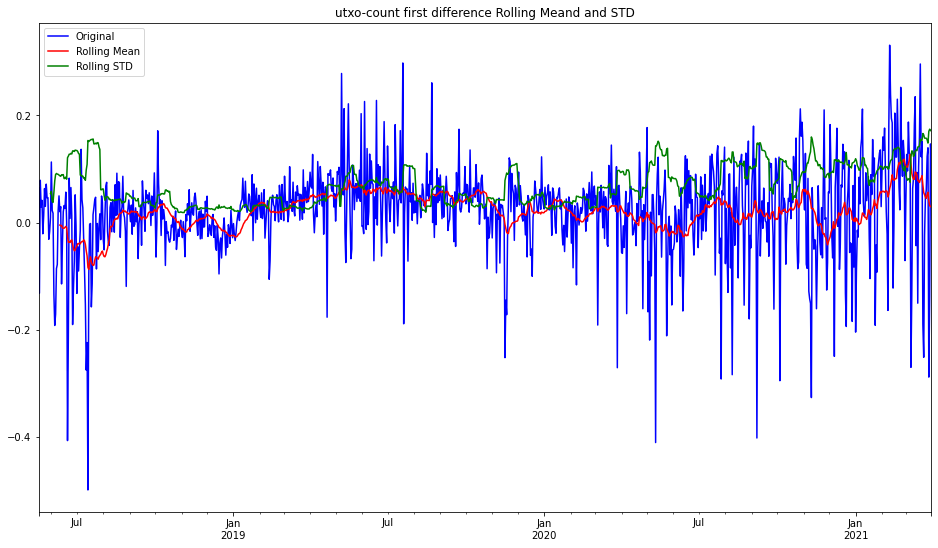

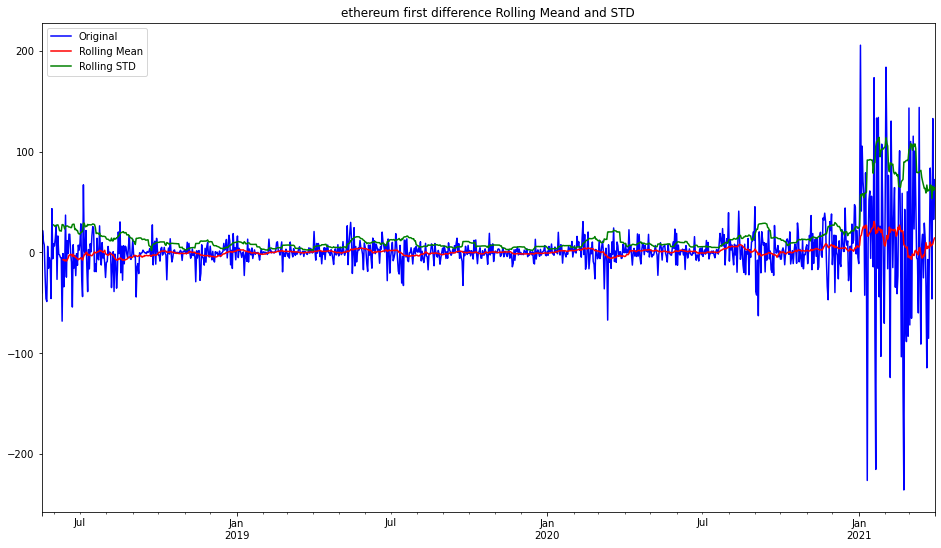

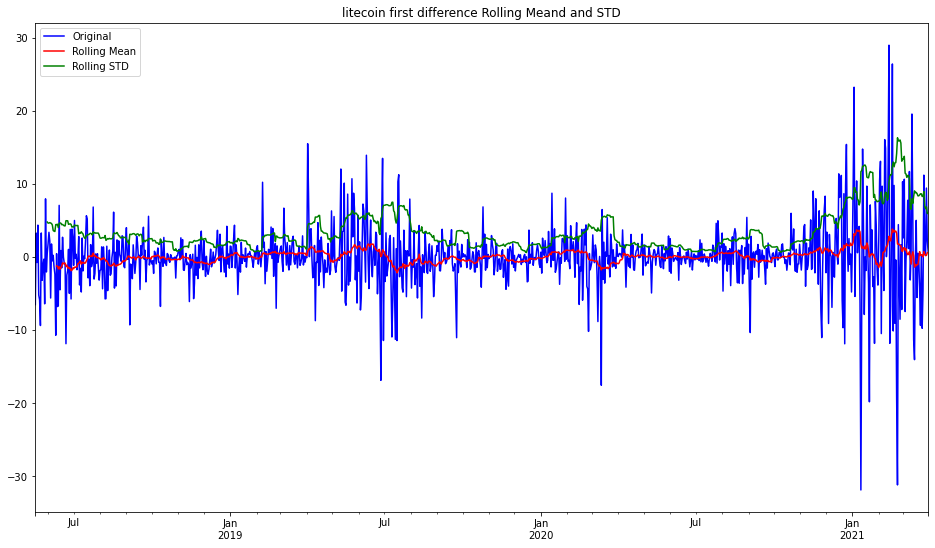

In [137]:
#Take first difference and perform ADF test again
df_var_diff = df_var_train.diff().dropna()

for i in df_var_diff.columns:
    print(i)
    test_stationarity(df_var_diff[i], title=i + ' first difference')

### Fitting the VAR model

In [144]:
var_model = VAR(df_var_diff)
var_order = var_model.select_order(maxlags=30)
var_order.summary()

,AIC,BIC,FPE,HQIC
0,26.89,26.91,4.745e+11,26.90
1,26.05,26.25,2.055e+11,26.13
2,25.82,26.20,1.641e+11,25.97
3,25.61,26.16,1.331e+11,25.82
4,25.45,26.17,1.129e+11,25.73
5,25.38,26.27,1.048e+11,25.72
6,25.29,26.36,9.622e+10,25.70
7,24.86,26.11*,6.282e+10,25.34
8,24.79,26.21,5.853e+10,25.33
9,24.75,26.35,5.639e+10,25.36


In [212]:
model_fitted = var_model.fit(30)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, May, 2021
Time:                     23:09:39
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    28.2367
Nobs:                     1020.00    HQIC:                   24.9824
Log likelihood:          -19323.0    FPE:                9.87318e+09
AIC:                      22.9903    Det(Omega_mle):     3.70510e+09
--------------------------------------------------------------------
Results for equation bitcoin
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 14.338185        19.948201            0.719           0.472
L1.bitcoin            -0.016099         0.058718           -0.274           0.784
L1.market-cap         -7.294042         3.561226      

### Forecasting

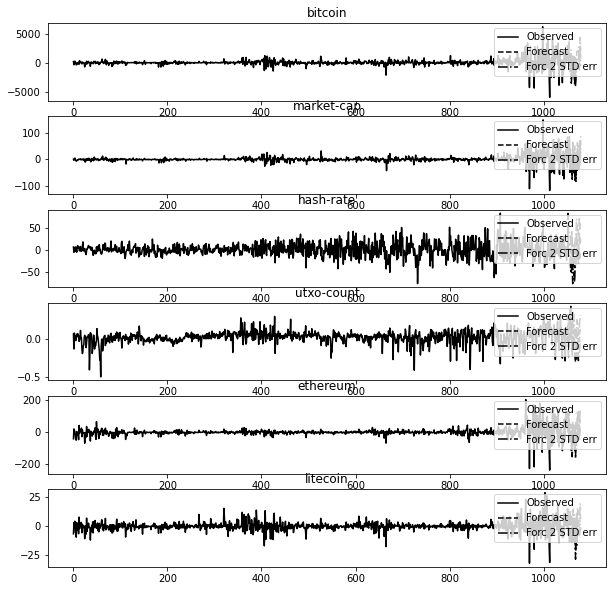

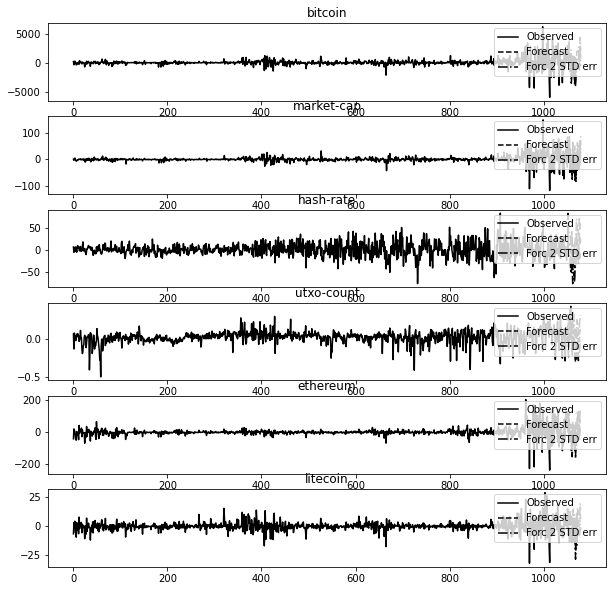

In [213]:
#Forecasting
forecast_input = df_var_diff.values[-30:]
fc = model_fitted.forecast(y=forecast_input, steps=30)


model_fitted.plot_forecast(30)

In [214]:
def inverse_transform(df_train, forecast_array):
    #Create dataframe of the forecast
    df_fc = pd.DataFrame(forecast_array, index=df_var.index[-30:], columns = df_var.columns + '_fc')
    
    #Undo differencing
    for i in df_var.columns:
        df_fc[str(i)+'_forecast'] = df_train[i].iloc[-1] + df_fc[str(i)+'_fc'].cumsum()
    
    col_list = [i+'_forecast' for i in df_train.columns]
    return df_fc[col_list]


forecast_df = inverse_transform(df_var_train, fc)
forecast_df

,bitcoin_forecast,market-cap_forecast,hash-rate_forecast,utxo-count_forecast,ethereum_forecast,litecoin_forecast
2021-04-01,60396.521731,1084.796230,1652.706580,75.373621,2009.817409,201.965853
2021-04-02,62444.371877,1151.015646,1662.045535,75.549101,2086.343759,210.058436
2021-04-03,64017.265859,1165.925850,1721.739526,75.552896,2113.424893,208.641578
2021-04-04,65295.851527,1197.463084,1734.666980,75.465400,2127.050027,216.289504
2021-04-05,68140.419305,1207.178381,1746.645845,75.502292,2204.471311,216.421407
2021-04-06,68707.236109,1274.429842,1760.809684,75.659372,2190.504773,209.335186
2021-04-07,68223.105945,1245.418651,1766.133299,75.893658,2207.830338,207.333317
2021-04-08,68245.790062,1264.071965,1764.897136,76.045293,2191.272418,213.630220
2021-04-09,69397.534326,1271.754961,1742.877634,76.325618,2199.700954,212.932952
2021-04-10,66922.563253,1250.154402,1722.249205,76.396900,2128.982672,206.395111


Text(0, 0.5, 'USD')

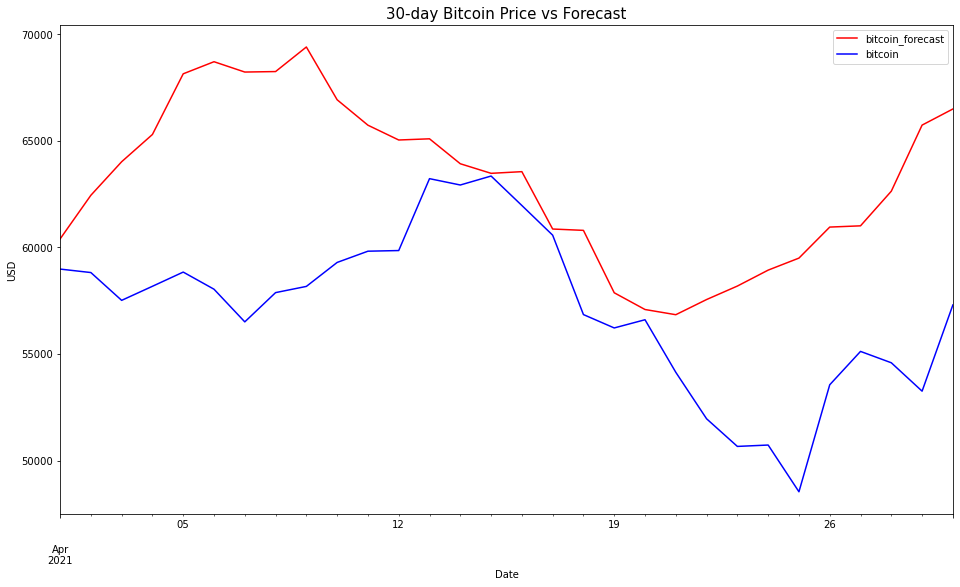

In [217]:
#Plot forecast
plt.figure(figsize=(16,9))
forecast_df['bitcoin_forecast'].plot(color='red', legend=True)
df_var_test['bitcoin'].plot(color='blue', legend=True)
plt.title('30-day Bitcoin Price vs Forecast', fontsize=15)
plt.xlabel('Date')
plt.ylabel('USD')

## Concluding Thoughts

Comparing the VAR model to the ARIMA model there is definitely improvement as the VAR model was able to forecast a months worth of results versus the ARIMA model which could only forecast one time step (1 day). 
The figure above describes the forecast and compares it to actual bitcoin values and we can see that the forecast wasn't really accurate.  
  
The significant reason behind why the forecasts aren't so accurate is due to the fact that bitcoins price is not only volitile, but subject to change due to a a large amount of exogenous variables that aren't all either numeric or included into the model. 
There are factors, such as new legislation restricting bitcoin or people/companies with a large public influence sharing their opinions or buying/selling bitcoin which could reselt in a sense of 'false demand' and have a large impact on the price.  
  
An example of this could be seen when Tesla bought 1.5 billion USD worth of bitcoin and plans to accept it as a form of payment in early  Feburary of 2021. $^7$ The value of bitcoin sharply rose shortly after this annoucement.  
  
Overall, this project showed us that predicting the price/trend of bitcoin using purely statistical methods is cumbersum and unintuitive. If one was to create a model with the intent of predicting the price of bitcoin for the purpose of trading, a machine learning model (NN, SNN, SVD, LSTM etc.) would probably be better suited. For the purposes of this project, it can be concluded that the trend of bitcoin price is hard to determine by pure statistical methods and there are a large number of variables that are taken into account when the price moves.       


## References 

$1$: Yahoo Finance, Litecoin USD, Accessed 2021-05-01, Online: https://finance.yahoo.com/quote/LTC-USD/history  
$2$: Yahoo Finance, Ethereum USD, Accessed 2021-05-01, Online: https://finance.yahoo.com/quote/ETH-USD/history?p=ETH-USD  
$3$ Blockchain, Unspent Transaction Outputs, Accessed 2021-05-01, Online: https://www.blockchain.com/charts/utxo-count  
$4$ Blockchain, Hash Rate, Accessed 2021-05-01, Online: https://www.blockchain.com/charts/hash-rate  
$5$ Blockchain, Market Capitalization, Accessed 2021-05-01, Online: https://www.blockchain.com/charts/market-cap  
$6$ Machine Learning Plus, Selva Prabhakaran, Vector Autoregression (VAR) – Comprehensive Guide with Examples in Python, Accessed 2021-05-03, Online: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/  
$7$ Investopedia, Jake Frankenfield, Bitcoin, Accessed 2021-05-09, Online: https://www.investopedia.com/terms/b/bitcoin.asp  
$8$ CNBC, Steve Kovach, Tesla buys $1.5 billion in bitcoin, plans to accept it as payment, Accessed 2021-05-10, Online: https://www.cnbc.com/2021/02/08/tesla-buys-1point5-billion-in-bitcoin.html  
